
# Programa Ingenia+ Data Science

Recordemos que un proyecto de data science tiene varias etapas:

1. Recolección de Datos
2. Exploración y Procesamiento de los datos
3. Modelado
4. Puesta en Producción

En clases anteriores, trabajamos con el dataset `StudentPerformace`. Pudimos observar el tipo de datos que teniamos y le hiciemos algunas transformaciones.

<font size=5> 🚀 👩🏽‍💻 Machine Learning: Aprendizaje Supervisado 📣</font>

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.cm as cm

In [3]:
# Importamos la librearia para separar el dataset.
from sklearn.model_selection import train_test_split

In [4]:
from sklearn.ensemble import RandomForestRegressor

In [5]:
from sklearn.metrics import mean_absolute_error

In [6]:
from sklearn.neighbors import KNeighborsClassifier

In [7]:
# Leemos nuevamente los datos de los estudiantes
students = pd.read_csv('StudentsPerformance.csv', delimiter=',')

In [8]:
students['puntaje_final'] = (students['math score'] + students['reading score'] + students['writing score']) / 3

## Evaluación del modelo de regresión

In [9]:
# Elimino aquellas variables que no quiero incluir en el modelo y las guardo en x.
x = students.drop(['math score', 'reading score', 'writing score', 'puntaje_final'],
                  axis=1)

In [10]:
# Ahora selecciono las etiquetas y las guardo en y.
y = students['puntaje_final']

In [11]:
x, y = np.array(x), np.array(y)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=42)

In [13]:
# Inicializo el modelo
regresor = RandomForestRegressor(criterion='absolute_error', random_state=42)

In [14]:
# Elimino aquellas variables que no quiero incluir en el modelo y las guardo en x.
# Keep x as a pandas DataFrame to perform one-hot encoding
x = students.drop(['math score', 'reading score', 'writing score', 'puntaje_final'],
                  axis=1)

lista_atributos = x.columns

# Ahora selecciono las etiquetas y las guardo en y.
y = students['puntaje_final']

# Apply one-hot encoding to categorical columns in x
x = pd.get_dummies(x, drop_first=True) # drop_first=True avoids multicollinearity

# Now convert to numpy arrays for sklearn compatibility
x, y = np.array(x), np.array(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2,
                                                    random_state=42)

# Update lista_atributos to reflect the new columns after one-hot encoding
# This is important for the feature_importance function later
lista_atributos = [col for col in range(X_train.shape[1])] # Use column indices for now


In [15]:
# Entreno el modelo
regresor.fit(X_train, y_train);

In [16]:
regresor.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'absolute_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 42,
 'verbose': 0,
 'warm_start': False}

Ahora evaluaremos el modelo. Primero, hacemos predicciones para el set de evaluación y luego lo comparamos con los valores reales.

In [17]:
# Predigo los valores para el set de testeo
y_pred = regresor.predict(X_test)

In [18]:
# Calculo el error medio absoluto
mean_absolute_error(y_test, y_pred)

7.854076666666665

In [19]:
# Calculo el error porcentual medio promedio
np.mean((np.abs(y_pred - y_test)/y_test)*100)

np.float64(21.04186305520996)

In [20]:
# Predigo los valores para el set de training
y_pred_train = regresor.predict(X_train)

In [21]:
mean_absolute_error(y_train, y_pred_train)

3.073193541666667

In [22]:
# Calculo el error porcentual medio promedio para el entrenamiento
np.mean((np.abs(y_train - y_pred_train)/y_train)*100)

np.float64(7.052134810011086)

Obtenemos la importancia de cada feature usando `feature_importances_`.

In [23]:
for x, y in list(zip(lista_atributos,regresor.feature_importances_)):
    print(f'Atributo: {x}, Importancia: {y}')

Atributo: 0, Importancia: 0.5141968724350359
Atributo: 1, Importancia: 0.05012950352164559
Atributo: 2, Importancia: 0.038486041443019134
Atributo: 3, Importancia: 0.04235966556136189
Atributo: 4, Importancia: 0.038228071079966744
Atributo: 5, Importancia: 0.033798964103316634
Atributo: 6, Importancia: 0.03595711612560126
Atributo: 7, Importancia: 0.04094196249496253
Atributo: 8, Importancia: 0.023804253558201205
Atributo: 9, Importancia: 0.038979292612997186
Atributo: 10, Importancia: 0.03904577094827603
Atributo: 11, Importancia: 0.049070379664937526
Atributo: 12, Importancia: 0.055002106450678497


**¿Podemos aceptar un modelo que prediga con un 20% de error?** ¿Qué podemos hacer ahora para mejorar nuestro modelo?

De manera de hacer una búsqueda, utilizaremos la función [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Recordemos que utilizamos un algoritmo de regresión, por lo tanto, vamos a usar los error para poder evaluar el desempeño de nuestro modelo. Primero creemos unas funciones que nos permitiran obtener los errores facilmente y graficar los resultados.

In [24]:
def evaluation(y_test, predictions):
    """
    Funcion que devuelve el error absoluto medio y el error porcentual absoluto medio.

    :param y_test: valores reales
    :param predictions: valores predichos

    :return: Devuelve el error absoluto medio y el error porcentual absoluto medio.
    """
    # Calcula mae
    mae = mean_absolute_error(y_test, predictions)
    #calculate mape
    mape = np.mean((np.abs(y_test - predictions)/y_test)*100)
    #print calculated values
    print(f"El error absoluto medio para el modelo es {round(mae, 2)}")
    print(f"El error porcentual absoluto medio para el modelo es {round(mape, 2)}")

In [25]:
def graph_real_pred(y_test, predictions, color):
    """
    Funcion que grafica los valores reales vs. predichos
    :param y_test: valores reales
    :param predictions: valores predichos
    :param color: color para el plot.

    :return: Scatterplot mostrando la relacion entre el valor real y el predicho
    """
    plt.scatter(y_test, predictions, c=color, s=10)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.xlabel('Real', size=15, labelpad=1)
    plt.ylabel('Predicted', size=15, labelpad=1)
    plt.show()

In [26]:
def feature_importance(model, feature_list):
    """
    Function that gets and plots the feature importance
    for the given model
    :param model: the model to evaluaate
    :param feature_list: a list of features contained in the model

    :returns a plot with feature importance
    """
    # Obtiene la lista de importancias
    importances = list(model.feature_importances_)
    # Junta los nombres de los atributos y las importancias
    feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, importances)]
    # Ordena por orden de importancia
    feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)
    # Print la lista de importancias
    [print('Variable: {} Importance: {}'.format(*pair)) for pair in feature_importances];
    # Colores
    colors = cm.rainbow(np.linspace(0, 1, len(feature_list)))

    # Caracteristicas en orden de importancia
    characteristics = [x[0] for x in feature_importances]
    # Obtiene las importancias
    importances_plot = [x[1] for x in feature_importances]
    # Grafica un bar plot
    plt.bar(characteristics, importances_plot, color=colors)
    # Personalizamos el grafico
    plt.xticks(list(range(len(characteristics))), characteristics, rotation = 90)
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['bottom'].set_visible(False)
    plt.gca().spines['left'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.gcf().subplots_adjust(bottom=0.3);

In [27]:
from sklearn.model_selection import GridSearchCV

In [28]:
# Valores para los parametros a optimizar
param_grid_rf = {
    'criterion': ['absolute_error'],
    'n_estimators': [70, 80, 90, 100, 120],
    'max_features': ['log2','sqrt'],
    'max_depth': [1, 3, 5, 10, 20, 50],
    'min_samples_leaf': [1, 3, 5, 10, 20, 50]
}

```python
modelo 1: mae, 70, log2, 1, 1 --> CV=5
modelo 2: mae, 80, log2, 1, 1
```

In [29]:
# Inicializamos un modelo
grid_regresor = RandomForestRegressor(random_state=42)

In [30]:
# Creamos la busqueda
rf_search = GridSearchCV(estimator=grid_regresor, param_grid=param_grid_rf,
                         cv=5, scoring='neg_mean_absolute_error', verbose=2, n_jobs=-1)

In [31]:
# Corremos el gridsearch con una validación usando 3 folds.
rf_search.fit(X_train, y_train)

Fitting 5 folds for each of 360 candidates, totalling 1800 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['absolute_error'],
                         'max_depth': [1, 3, 5, 10, 20, 50],
                         'max_features': ['log2', 'sqrt'],
                         'min_samples_leaf': [1, 3, 5, 10, 20, 50],
                         'n_estimators': [70, 80, 90, 100, 120]},
             scoring='neg_mean_absolute_error', verbose=2)

**¿Cuál es nuestro mejor estimador?**

In [32]:
rf_search.best_estimator_

RandomForestRegressor(criterion='absolute_error', max_depth=10,
                      max_features='log2', min_samples_leaf=3, n_estimators=70,
                      random_state=42)

In [33]:
rf_search.best_params_

{'criterion': 'absolute_error',
 'max_depth': 10,
 'max_features': 'log2',
 'min_samples_leaf': 3,
 'n_estimators': 70}

In [34]:
rf_search.best_score_

np.float64(-7.254037797619047)

In [35]:
# Asignamos el mejor estimador a mejor_regresor
mejor_regresor = RandomForestRegressor(criterion='absolute_error', n_estimators=70, max_depth=10, max_features='log2', min_samples_leaf=10)

In [36]:
# Entrenamos el modelo
mejor_regresor.fit(X_train, y_train)

RandomForestRegressor(criterion='absolute_error', max_depth=10,
                      max_features='log2', min_samples_leaf=10,
                      n_estimators=70)

In [37]:
# Hacemos la prediccion para el test de evaluación
predicciones = mejor_regresor.predict(X_test)

In [38]:
# Error
evaluation(y_test, predicciones)

El error absoluto medio para el modelo es 7.56
El error porcentual absoluto medio para el modelo es 20.88


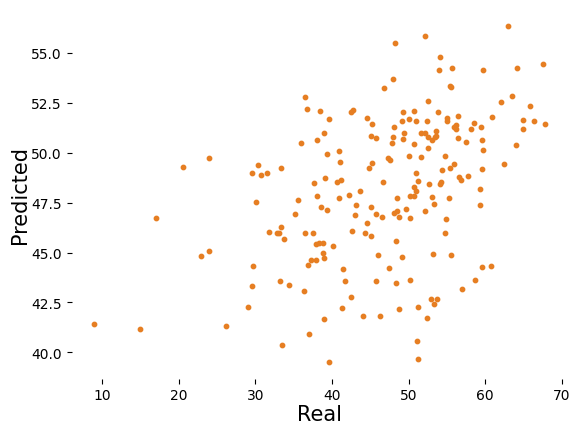

In [39]:
# Correlacion
graph_real_pred(y_test, predicciones, color='#E67E22')

Variable: 12 Importance: 0.24
Variable: 1 Importance: 0.18
Variable: 0 Importance: 0.17
Variable: 11 Importance: 0.16
Variable: 7 Importance: 0.05
Variable: 2 Importance: 0.03
Variable: 3 Importance: 0.03
Variable: 4 Importance: 0.03
Variable: 5 Importance: 0.03
Variable: 6 Importance: 0.03
Variable: 10 Importance: 0.03
Variable: 9 Importance: 0.02
Variable: 8 Importance: 0.01


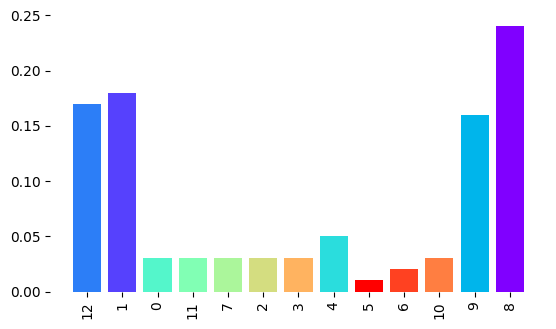

In [40]:
# Importancia de cada feature
feature_importance(mejor_regresor, lista_atributos)

## Evaluacion de un modelo de Clasificación

In [41]:
# metricas
from sklearn.metrics import (
    accuracy_score,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)

In [42]:
students['aprobado'] = students['puntaje_final'].apply(lambda x: 0 if x < 60 else 1)

In [43]:
xc = students.drop(['math score', 'reading score', 'writing score', 'puntaje_final', 'aprobado'],
                  axis=1)

In [44]:
yc = students['aprobado']

In [45]:
# Apply one-hot encoding to categorical columns in xc
# drop_first=True avoids multicollinearity
xc = pd.get_dummies(xc, drop_first=True)

In [46]:
xc, yc = np.array(xc), np.array(yc)

In [47]:
X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(xc, yc, test_size=0.2,
                                                    random_state=42)

In [48]:
knn = KNeighborsClassifier()

In [49]:
# Entrenamos el modelo
knn.fit(X_train_c, y_train_c);

In [50]:
# Predecimos
predicciones_cla = knn.predict(X_test_c)

In [51]:
predicciones_train = knn.predict(X_train_c)

In [52]:
accuracy = accuracy_score(y_train_c, predicciones_train)*100
print(f'{round(accuracy, 2)}%')

87.0%


In [53]:
accuracy = accuracy_score(y_test_c, predicciones_cla)*100
print(f'{round(accuracy, 2)}%')

92.0%


**Metricas**

Matriz de confusión:

True Negative (TN)  |  False positive (FP)   
= = = = = = = = = = = = = = = = = = = = =       
False negative (FN) | True positive (TP)  


In [62]:
print(f"Accuracy: {accuracy_score(y_test_c, predicciones_cla)*100 :.2f}%")
print(f"Precision: {precision_score(y_test_c, predicciones_cla)*100 :.2f}%")
print(f"Recall: {recall_score(y_test_c, predicciones_cla)*100 :.2f}%")
print(f"F1 score: {f1_score(y_test_c, predicciones_cla)*100 :.2f}%")

Accuracy: 92.00%
Precision: 0.00%
Recall: 0.00%
F1 score: 0.00%


## Buscando el 'mejor' modelo (Clasificación)

Ahora vamos a optimizar los parameteros del clasificador kNN. Para eso podemos revisar en la documentación que parametros se pueden [optimizar](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html).

Vamos a buscar el mejor k:

In [63]:
####
ACC_train = []
ACC_test = []
vecinos = [1, 3, 5, 10, 15, 20, 25, 30]
for n in vecinos:
    clf = KNeighborsClassifier(n_neighbors=n)
    clf.fit(X_train_c, y_train_c)
    y_train_pred = clf.predict(X_train_c)
    train_acc = accuracy_score(y_train_c, y_train_pred)
    ACC_train.append(train_acc)
    y_test_pred = clf.predict(X_test_c)
    test_acc = accuracy_score(y_test_c, y_test_pred)
    ACC_test.append(test_acc)

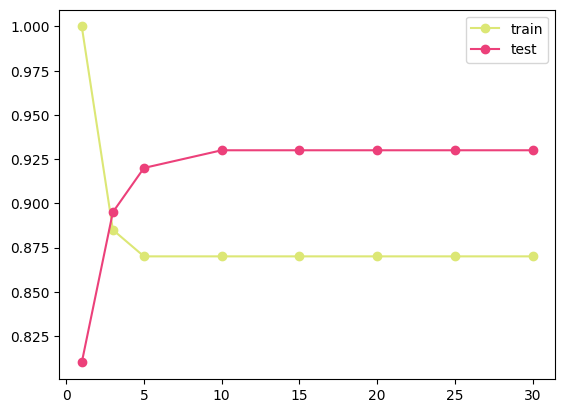

In [64]:
plt.plot(vecinos,ACC_train,'o-',label='train', color='#DCE775')
plt.plot(vecinos,ACC_test,'o-',label='test', color='#EC407A')
plt.legend()

In [65]:
# Valores para los parametros a optimizar
param_grid_vec = {
    'n_neighbors': [18, 20, 22],
    'weights': ['uniform','distance'],
    'metric': ['euclidean', 'manhattan'],
}

In [66]:
knn_search = KNeighborsClassifier()

In [67]:
vecinos_search = GridSearchCV(estimator=knn_search, param_grid=param_grid_vec,
                         cv=3, verbose=2, n_jobs=-1)

In [68]:
vecinos_search.fit(X_train_c, y_train_c)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


GridSearchCV(cv=3, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'metric': ['euclidean', 'manhattan'],
                         'n_neighbors': [18, 20, 22],
                         'weights': ['uniform', 'distance']},
             verbose=2)

In [69]:
knn_best = vecinos_search.best_estimator_

**¿Cuál es nuestro mejor estimador?**

In [70]:
knn_best.fit(X_train_c, y_train_c)

KNeighborsClassifier(metric='euclidean', n_neighbors=18)

In [71]:
vecinos_search.best_score_

np.float64(0.8700027221612082)

In [72]:
vecinos_search.best_estimator_

KNeighborsClassifier(metric='euclidean', n_neighbors=18)

In [73]:
new_predictions = knn_best.predict(X_test_c)

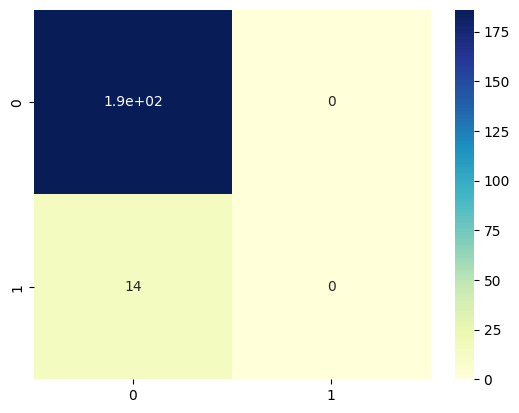

In [74]:
plt.figure()
random_confusion = confusion_matrix(y_test_c, new_predictions)
sns.heatmap(random_confusion, cmap="YlGnBu",annot=True);

In [75]:
print(f"Accuracy: {accuracy_score(y_test_c, new_predictions)*100 :.2f}%")
print(f"Precision: {precision_score(y_test_c, new_predictions)*100 :.2f}%")
print(f"Recall: {recall_score(y_test_c, new_predictions)*100 :.2f}%")
print(f"F1 score: {f1_score(y_test_c, new_predictions)*100 :.2f}%")

Accuracy: 93.00%
Precision: 0.00%
Recall: 0.00%
F1 score: 0.00%


c:\Users\Jorgelina\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
